In [10]:
'''
import pandas as pd
import os
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Define paths

train_csv_path = r"C:\Users\rikdu\Downloads\SIIMS Melanoma\subfolders\subfolder_1\train.csv"
validation_csv_path = r"C:\Users\rikdu\Downloads\SIIMS Melanoma\subfolders\subfolder_1\validation.csv"
augmented_images_path = r"C:\Users\rikdu\Downloads\SIIMS Melanoma\augmented images\augmented_images_v2"
original_train_images_path = r"C:\Users\rikdu\Downloads\SIIMS Melanoma\train"

# Load data
train_df = pd.read_csv(train_csv_path)
validation_df = pd.read_csv(validation_csv_path)

# Load images
def load_images(df, img_paths):
    images = []
    for img_path in img_paths:
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img)
        images.append(img_array)
    return np.array(images)

train_images = load_images(train_df, train_df['image_path'])
validation_images = load_images(validation_df, validation_df['image_path'])

# Normalize images
train_images = train_images / 255.0
validation_images = validation_images / 255.0

# Extract metadata and labels
train_metadata = train_df[['age_approx']].values  # Example: Extracting age
validation_metadata = validation_df[['age_approx']].values

# Labels
train_labels = train_df['target'].values
validation_labels = validation_df['target'].values

# Define model
inp_image = Input((224, 224, 3))
inp_metadata = Input((train_metadata.shape[1],))

def inception_block(x, base_channels=16):
    conv_1 = Conv2D(base_channels * 2, 1, 1, activation='relu')(x)
    conv_2_a = Conv2D(base_channels * 2, 1, 1, activation='relu')(x)
    conv_2_b = Conv2D(base_channels * 2, 3, 1, padding='same', activation='relu')(conv_2_a)
    conv_3_a = Conv2D(base_channels, 1, 1, activation='relu')(x)
    conv_3_b = Conv2D(base_channels, 5, 1, padding='same', activation='relu')(conv_3_a)
    mpool_4_a = MaxPooling2D(3, 1, padding='same')(x)
    conv_4_b = Conv2D(base_channels, 1, 1, activation='relu')(mpool_4_a)
    return Concatenate(axis=-1)([conv_1, conv_2_b, conv_3_b, conv_4_b])

block_1 = inception_block(inp_image)
block_2 = inception_block(block_1, base_channels=8)
block_3 = inception_block(block_2, base_channels=8)

gap = GlobalAveragePooling2D()(block_3)
flatn = Flatten()(gap)

# Metadata branch
metadata_dense = Dense(32, activation='relu')(inp_metadata)
metadata_output = Dense(16, activation='relu')(metadata_dense)

# Concatenate image and metadata branches
concat = Concatenate(axis=-1)([flatn, metadata_output])
output = Dense(1, activation="sigmoid")(concat)

model = Model(inputs=[inp_image, inp_metadata], outputs=output)

# Compile model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("C:\\Users\\rikdu\\Downloads\\SIIMS Melanoma\\subfolders\\subfolder_1\\best_model.h5", 
                                   monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# Train the model
history = model.fit(
    [train_images, train_metadata], train_labels,
    validation_data=([validation_images, validation_metadata], validation_labels),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

# Save the model
model.save("C:\\Users\\rikdu\\Downloads\\SIIMS Melanoma\\subfolders\\subfolder_1\\final_model.h5")
'''

Epoch 1/10
350/350 [==============================] - 1116s 3s/step - loss: 0.2835 - accuracy: 0.8857 - val_loss: 0.1155 - val_accuracy: 0.9643 - lr: 0.0010
Epoch 2/10
350/350 [==============================] - 1084s 3s/step - loss: 0.1503 - accuracy: 0.9601 - val_loss: 0.1076 - val_accuracy: 0.9704 - lr: 0.0010
Epoch 3/10
350/350 [==============================] - 1153s 3s/step - loss: 0.1482 - accuracy: 0.9599 - val_loss: 0.1156 - val_accuracy: 0.9736 - lr: 0.0010
Epoch 4/10
350/350 [==============================] - 1098s 3s/step - loss: 0.1407 - accuracy: 0.9621 - val_loss: 0.1024 - val_accuracy: 0.9682 - lr: 0.0010
Epoch 5/10
350/350 [==============================] - 1092s 3s/step - loss: 0.1406 - accuracy: 0.9634 - val_loss: 0.1091 - val_accuracy: 0.9643 - lr: 0.0010
Epoch 6/10
350/350 [==============================] - 1059s 3s/step - loss: 0.1371 - accuracy: 0.9640 - val_loss: 0.1024 - val_accuracy: 0.9693 - lr: 0.0010
Epoch 7/10
350/350 [==============================] - 1069

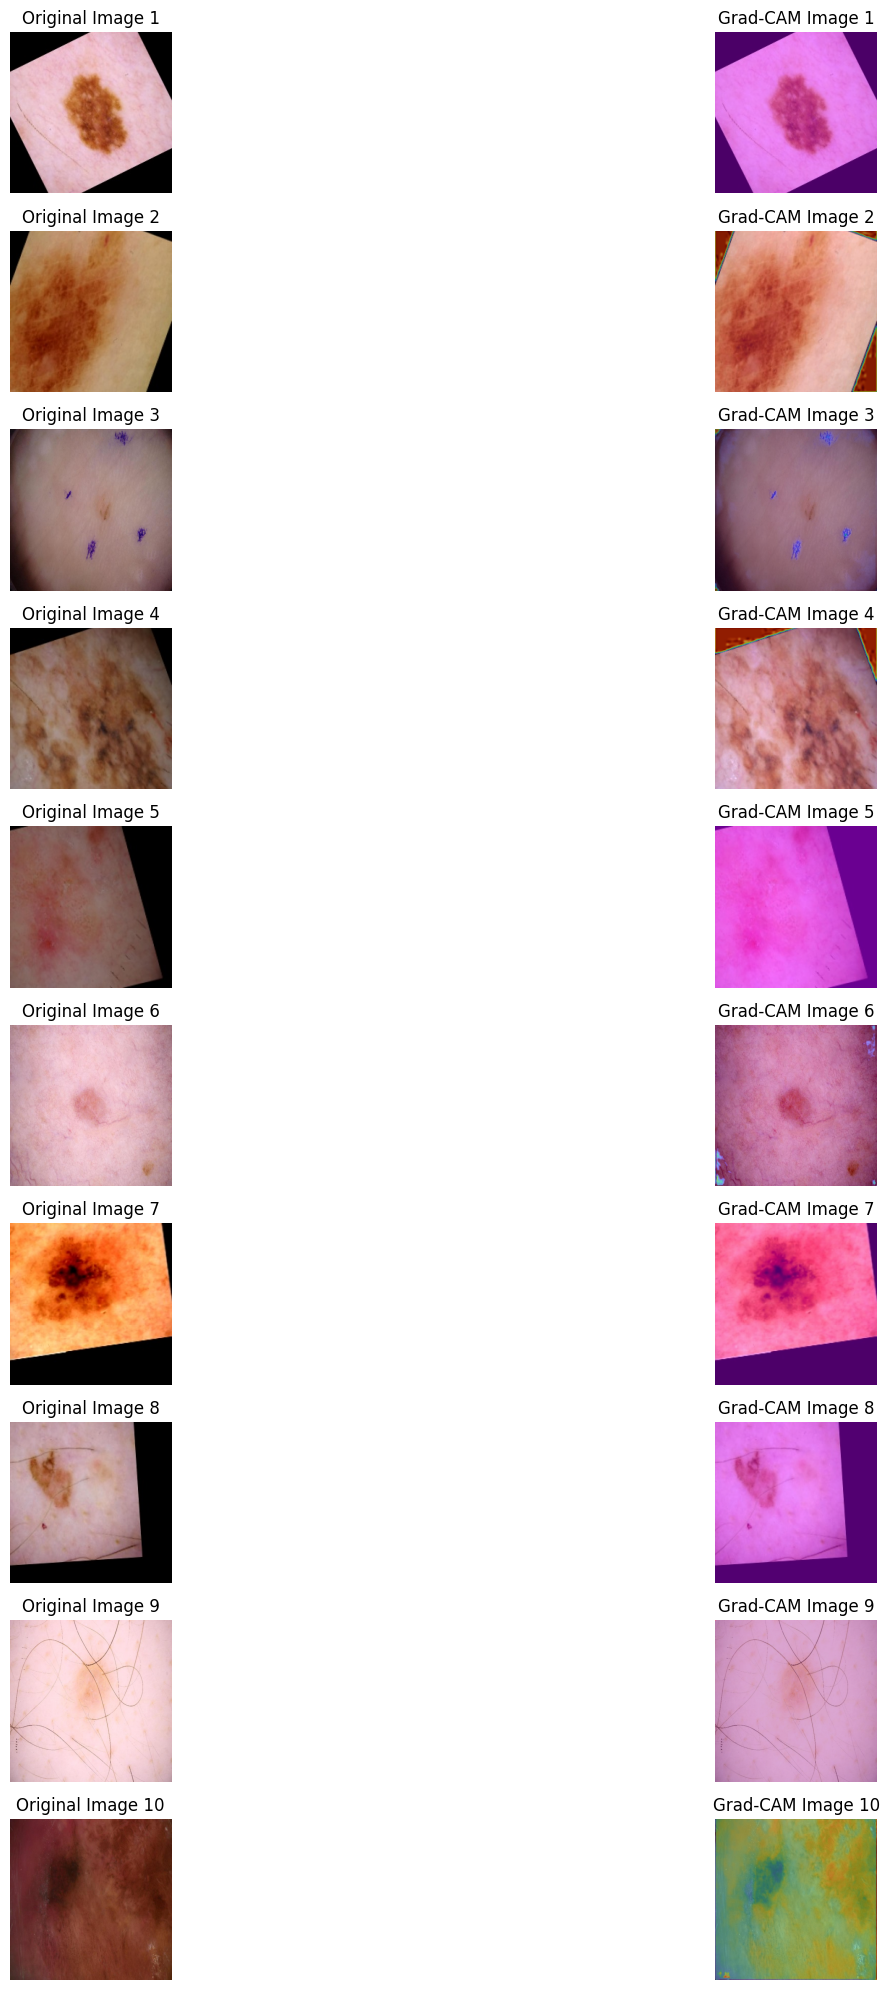

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Load the trained model
model = tf.keras.models.load_model(r"C:\Users\rikdu\Downloads\SIIMS Melanoma\subfolders\subfolder_1\final_model.h5")

# Define function for Grad-CAM
def make_gradcam_heatmap(img_array, metadata_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.input[0], model.input[1]], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model([img_array, metadata_array])
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Define function to display heatmap
def display_gradcam(img_path, heatmap, alpha=0.6):  # Increase alpha for more prominence
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)
    # Use a different colormap for better visibility
    colormap = plt.get_cmap("turbo")  # Use turbo colormap
    colormap_colors = colormap(np.arange(256))[:, :3]
    heatmap_colored = colormap_colors[heatmap]

    heatmap_colored = image.array_to_img(heatmap_colored)
    heatmap_colored = heatmap_colored.resize((img.shape[1], img.shape[0]))
    heatmap_colored = image.img_to_array(heatmap_colored)

    superimposed_img = heatmap_colored * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)

    return superimposed_img

# Load validation data
validation_csv_path = r"C:\Users\rikdu\Downloads\SIIMS Melanoma\subfolders\subfolder_1\validation.csv"
validation_df = pd.read_csv(validation_csv_path)

# Select 10 random samples
sampled_df = validation_df.sample(n=10, random_state=42)

# Display original and Grad-CAM images
plt.figure(figsize=(20, 20))

for idx, row in enumerate(sampled_df.itertuples()):
    img_path = row.image_path
    metadata = np.array([[row.age_approx]])  # Example metadata (e.g., age)
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = np.expand_dims(image.img_to_array(img) / 255.0, axis=0)
    metadata_array = np.expand_dims(metadata, axis=0)

    # Generate Grad-CAM heatmap
    last_conv_layer_name = 'conv2d_8'  # Name of the last conv layer in your model
    heatmap = make_gradcam_heatmap(img_array, metadata_array, model, last_conv_layer_name)

    # Display Grad-CAM
    gradcam_img = display_gradcam(img_path, heatmap)
    
    # Show original image
    plt.subplot(10, 2, 2*idx + 1)
    plt.imshow(image.load_img(img_path))
    plt.title(f"Original Image {idx+1}")
    plt.axis('off')

    # Show Grad-CAM image
    plt.subplot(10, 2, 2*idx + 2)
    plt.imshow(gradcam_img)
    plt.title(f"Grad-CAM Image {idx+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Concatenate, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Define paths
train_csv_path = r"C:\Users\rikdu\Downloads\SIIMS Melanoma\subfolders\subfolder_1\train.csv"
validation_csv_path = r"C:\Users\rikdu\Downloads\SIIMS Melanoma\subfolders\subfolder_1\validation.csv"

# Load data
train_df = pd.read_csv(train_csv_path)
validation_df = pd.read_csv(validation_csv_path)

# Load images
def load_images(df, img_paths):
    images = []
    for img_path in img_paths:
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img)
        images.append(img_array)
    return np.array(images)

train_images = load_images(train_df, train_df['image_path'])
validation_images = load_images(validation_df, validation_df['image_path'])

# Normalize images
train_images = train_images / 255.0
validation_images = validation_images / 255.0

# Extract metadata and labels
metadata_features = ['sex', 'age_approx', 'anatom_site_general_challenge']
train_metadata = train_df[metadata_features]
validation_metadata = validation_df[metadata_features]

# Convert categorical features to numerical
train_metadata.loc[:, 'sex'] = train_metadata['sex'].map({'male': 0, 'female': 1})
validation_metadata.loc[:, 'sex'] = validation_metadata['sex'].map({'male': 0, 'female': 1})
train_metadata = pd.get_dummies(train_metadata, columns=['anatom_site_general_challenge'])
validation_metadata = pd.get_dummies(validation_metadata, columns=['anatom_site_general_challenge'])

# Align columns in train and validation sets (handle missing columns after get_dummies)
train_metadata, validation_metadata = train_metadata.align(validation_metadata, join='outer', axis=1, fill_value=0)

# Convert metadata to float32
train_metadata = train_metadata.astype(np.float32)
validation_metadata = validation_metadata.astype(np.float32)

# Convert labels to float32
train_labels = train_df['target'].astype(np.float32).values
validation_labels = validation_df['target'].astype(np.float32).values

# Define model
inp_image = Input((224, 224, 3))
inp_metadata = Input((train_metadata.shape[1],))

def inception_block(x, base_channels=16):
    conv_1 = Conv2D(base_channels * 2, 1, 1, activation='relu')(x)
    conv_2_a = Conv2D(base_channels * 2, 1, 1, activation='relu')(x)
    conv_2_b = Conv2D(base_channels * 2, 3, 1, padding='same', activation='relu')(conv_2_a)
    conv_3_a = Conv2D(base_channels, 1, 1, activation='relu')(x)
    conv_3_b = Conv2D(base_channels, 5, 1, padding='same', activation='relu')(conv_3_a)
    mpool_4_a = MaxPooling2D(3, 1, padding='same')(x)
    conv_4_b = Conv2D(base_channels, 1, 1, activation='relu')(mpool_4_a)
    return Concatenate(axis=-1)([conv_1, conv_2_b, conv_3_b, conv_4_b])

block_1 = inception_block(inp_image)
block_2 = inception_block(block_1, base_channels=8)
block_3 = inception_block(block_2, base_channels=8)

gap = GlobalAveragePooling2D()(block_3)
flatn = Flatten()(gap)

# Metadata branch
metadata_dense = Dense(32, activation='relu')(inp_metadata)
metadata_output = Dense(16, activation='relu')(metadata_dense)

# Concatenate image and metadata branches
concat = Concatenate(axis=-1)([flatn, metadata_output])
output = Dense(1, activation="sigmoid")(concat)

model = Model(inputs=[inp_image, inp_metadata], outputs=output)

# Compile model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(r"C:\Users\rikdu\Downloads\SIIMS Melanoma\subfolders\subfolder_1\best_model.h5", 
                                   monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# Train the model
history = model.fit(
    [train_images, train_metadata], train_labels,
    validation_data=([validation_images, validation_metadata], validation_labels),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

# Save the model
model.save(r"C:\Users\rikdu\Downloads\SIIMS Melanoma\subfolders\subfolder_1\exp_model.h5")


Epoch 1/10
350/350 [==============================] - 1146s 3s/step - loss: 0.2285 - accuracy: 0.9130 - val_loss: 0.1221 - val_accuracy: 0.9629 - lr: 0.0010
Epoch 2/10
350/350 [==============================] - 1090s 3s/step - loss: 0.1285 - accuracy: 0.9636 - val_loss: 0.1479 - val_accuracy: 0.9482 - lr: 0.0010
Epoch 3/10
350/350 [==============================] - 1080s 3s/step - loss: 0.0889 - accuracy: 0.9774 - val_loss: 0.3528 - val_accuracy: 0.8539 - lr: 0.0010
Epoch 4/10
350/350 [==============================] - 1087s 3s/step - loss: 0.0716 - accuracy: 0.9846 - val_loss: 0.3242 - val_accuracy: 0.8693 - lr: 2.0000e-04


In [11]:
# List all layers in the model
for i, layer in enumerate(model.layers):
    print(i, layer.name)


0 input_5
1 conv2d_37
2 conv2d_39
3 max_pooling2d_6
4 conv2d_36
5 conv2d_38
6 conv2d_40
7 conv2d_41
8 concatenate_8
9 conv2d_43
10 conv2d_45
11 max_pooling2d_7
12 conv2d_42
13 conv2d_44
14 conv2d_46
15 conv2d_47
16 concatenate_9
17 conv2d_49
18 conv2d_51
19 max_pooling2d_8
20 conv2d_48
21 conv2d_50
22 conv2d_52
23 conv2d_53
24 concatenate_10
25 input_6
26 global_average_pooling2d_2
27 dense_6
28 flatten_2
29 dense_7
30 concatenate_11
31 dense_8


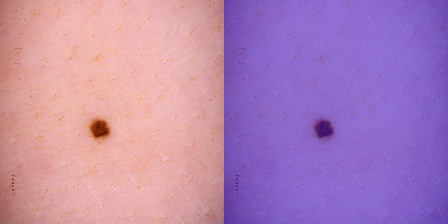

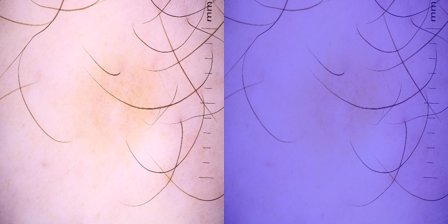

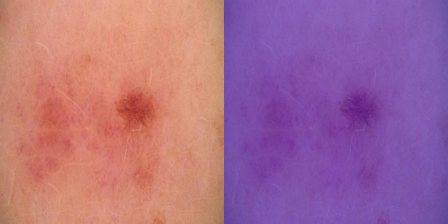

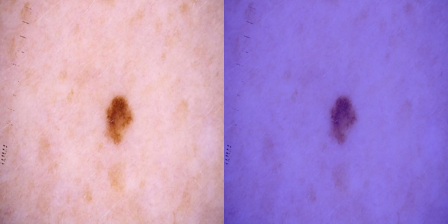

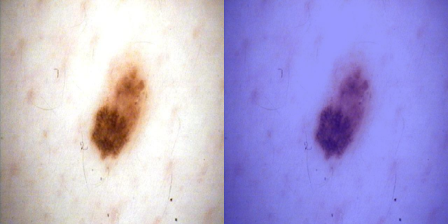

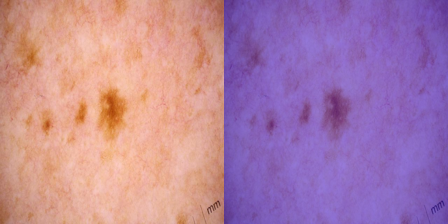

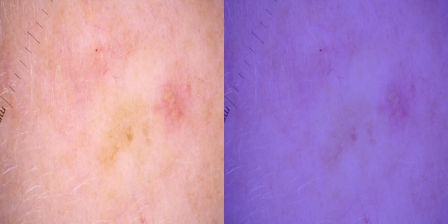

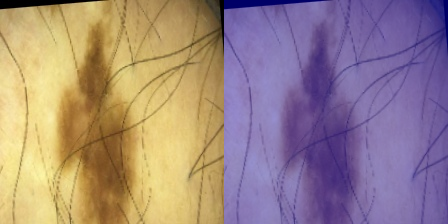

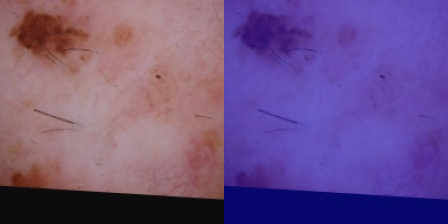

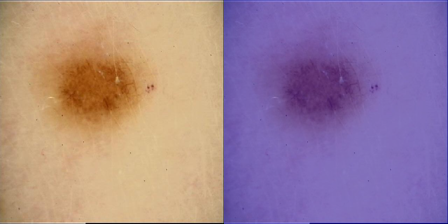

In [18]:
import numpy as np
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
from IPython.display import display
from PIL import Image as PilImage, ImageOps, ImageEnhance

# Load the trained model
model = load_model(r"C:\Users\rikdu\Downloads\SIIMS Melanoma\subfolders\subfolder_1\exp_model.h5")

def get_img_array(img_path, size):
    img = load_img(img_path, target_size=size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def make_gradcam_heatmap(img_array, metadata_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model([img_array, metadata_array])
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, alpha=0.4):
    img = PilImage.open(img_path).resize((224, 224))

    heatmap = np.uint8(255 * heatmap)
    heatmap = PilImage.fromarray(heatmap).resize(img.size, PilImage.Resampling.BILINEAR)
    heatmap = ImageOps.colorize(heatmap, black="blue", white="yellow")

    heatmap = ImageEnhance.Brightness(heatmap).enhance(2)  # Increase the brightness of the heatmap

    img = PilImage.blend(img, heatmap, alpha=alpha)
    return img

# Use the correct layer name identified from the above list
last_conv_layer_name = "conv2d_53"

# Loop through the first 10 samples in the validation set
for i in range(10):
    img_path = validation_df['image_path'].iloc[i]
    img_array = get_img_array(img_path, size=(224, 224))
    metadata_array = np.expand_dims(validation_metadata.iloc[i].values, axis=0)

    heatmap = make_gradcam_heatmap(img_array, metadata_array, model, last_conv_layer_name)
    gradcam_img = save_and_display_gradcam(img_path, heatmap)

    # Display original and Grad-CAM images side by side
    original_img = PilImage.open(img_path).resize((224, 224))
    comparison_img = PilImage.new('RGB', (original_img.width * 2, original_img.height))
    comparison_img.paste(original_img, (0, 0))
    comparison_img.paste(gradcam_img, (original_img.width, 0))
    display(comparison_img)
